# Introduction
The goal of this study is to investigate how Twitter, a popular social media platform, can be leveraged in detecting early risk of depression of its users.

In [2]:
#importing libreries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

from wordcloud import WordCloud

import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [3]:
#Importing Dataset
data_dir = "/CSE465/Dataset"

## Classification of depressive and normal tweets

### Datasets

For this analysis, the [Sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset is used. 

In [4]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv(os.path.join(data_dir, 'training.1600000.processed.noemoticon.csv'), encoding=encoding, names=col_names)

In [5]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For this experiment, I took a random sample of 8000 tweets.

In [6]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


Since there is no readily available public dataset on depression, I found a dataset scraped by [Twint](https://github.com/eddieir/Depression_detection_using_Twitter_post/blob/master/depressive_tweets_processed.csv).  

In [9]:
col_names = ['id', 'text']
df2 = pd.read_csv(os.path.join(data_dir, 'H:\CSE465\Dataset\depressive-tweets-processed\depressive_tweets_processed.csv'), sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [11]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [12]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10345 entries, 1411888 to 277920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10313 non-null  object
 1   label   10345 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


### Preprocessing

In [21]:
contractions = pd.read_json(os.path.join(data_dir, 'H:\CSE465\contractions.json'), typ='series')
contractions = contractions.to_dict()

In [22]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [23]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [27]:
X = clean_tweets([tweet for tweet in df['text']])

## Word analysis

In [28]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

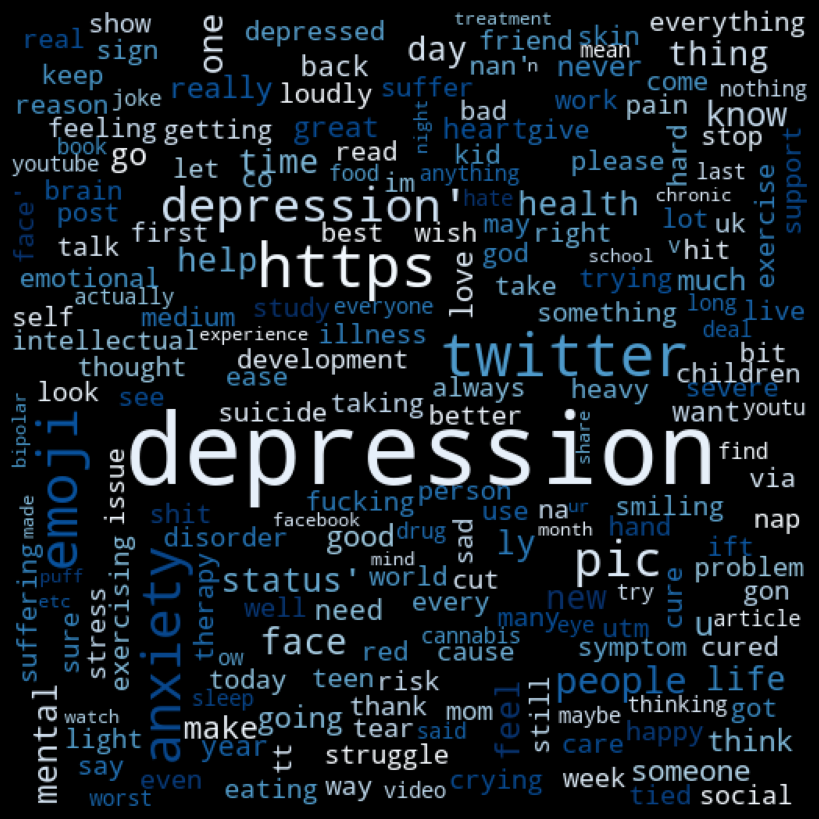

In [29]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

It's easy to spot words that are indicative of depression in these tweets: depression, treatment, suffering, crying, help, struggle, risk, hate, sad, anxiety, disorder, suicide, stress, therapy, mental health, emotional, bipolar.

### Tokenization

In [30]:
MAX_NUM_WORDS = 10000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [31]:
word_vector = tokenizer.texts_to_sequences(X)

In [32]:
word_index = tokenizer.word_index

In [33]:
vocab_size = len(word_index)
vocab_size   # num of unique tokens

20670

In [34]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [35]:
input_tensor.shape

(10345, 140)

## Baseline model

### TF-IDF classifier

In [36]:
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [37]:
tdidf_tensor.shape

(10345, 10000)

### Training

In [38]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)

In [39]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

SVC()

In [40]:
predictions = baseline_model.predict(x_test)

In [41]:
accuracy_score(y_test, predictions)

0.9964561855670103

In [42]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99553   1.00000   0.99776      2448
           1    1.00000   0.98323   0.99154       656

    accuracy                        0.99646      3104
   macro avg    0.99776   0.99162   0.99465      3104
weighted avg    0.99647   0.99646   0.99645      3104



## LTSM model

Let's improve our model with LTSM. 

### Word embedding

In [47]:
EMBEDDING_FILE = os.path.join(data_dir, 'H:\CSE465\googles-trained-word2vec-model-in-python\GoogleNews-vectors-negative300.bin.gz')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [48]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

In [50]:
for word, idx in word_index.items():
    if word2vec.key_to_index.get(word) is not None and idx < MAX_NUM_WORDS:
        embedding_matrix[idx] = word2vec.get_vector(word)


### Training

In [51]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [52]:
# Compile the model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)

In [54]:
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
453/453 [==============================] - 218s 470ms/step - loss: 0.0852 - accuracy: 0.9720
Epoch 2/10
453/453 [==============================] - 217s 479ms/step - loss: 0.0176 - accuracy: 0.9954
Epoch 3/10
453/453 [==============================] - 225s 496ms/step - loss: 0.0057 - accuracy: 0.9986
Epoch 4/10
453/453 [==============================] - 222s 489ms/step - loss: 0.0066 - accuracy: 0.9985
Epoch 5/10
453/453 [==============================] - 222s 491ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 6/10
453/453 [==============================] - 225s 496ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 7/10
453/453 [==============================] - 222s 489ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 8/10
453/453 [==============================] - 224s 495ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 9/10
453/453 [==============================] - 230s 509ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 10/10
453/453 [==============================] - 234s 517m

In [55]:
preds = model.predict(x_test)

97/97 [==============================] - 24s 244ms/step


In [56]:
preds  = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           0    0.99414   0.99456   0.99435      2389
           1    0.98179   0.98042   0.98111       715

    accuracy                        0.99130      3104
   macro avg    0.98797   0.98749   0.98773      3104
weighted avg    0.99130   0.99130   0.99130      3104



## Playing with other models

### Naive Baye's

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, df.label, test_size=0.3, random_state = 42)

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [59]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9014175257731959
              precision    recall  f1-score   support

           0    0.88731   0.99832   0.93955      2382
           1    0.99057   0.58172   0.73298       722

    accuracy                        0.90142      3104
   macro avg    0.93894   0.79002   0.83627      3104
weighted avg    0.91133   0.90142   0.89150      3104



## Linear Support Vector

In [60]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [61]:
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9829252577319587
              precision    recall  f1-score   support

           0    0.97823   1.00000   0.98900      2382
           1    1.00000   0.92659   0.96190       722

    accuracy                        0.98293      3104
   macro avg    0.98912   0.96330   0.97545      3104
weighted avg    0.98330   0.98293   0.98269      3104



## Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

c:\Users\aquat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [63]:
y_pred = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9677835051546392
              precision    recall  f1-score   support

           0    0.98512   0.97271   0.97888      2382
           1    0.91356   0.95152   0.93216       722

    accuracy                        0.96778      3104
   macro avg    0.94934   0.96212   0.95552      3104
weighted avg    0.96848   0.96778   0.96801      3104

